In [60]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics.pairwise import linear_kernel
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np

In [5]:
emails = pd.read_csv(r"C:\Users\Sumit4.Singh\Downloads\enron-email-dataset\emails.csv")

(517401, 2)


In [35]:
emails = emails.head(10000)

In [36]:
emails.shape

(10000, 2)

In [37]:
def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

In [38]:
def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

In [39]:
def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

In [40]:
email_df = pd.DataFrame(parse_into_emails(emails.message))

In [41]:
email_df.head()

,body,to,from_
0,Here is our forecast,tim.belden@enron.com,phillip.allen@enron.com
1,Traveling to have a business meeting takes the...,john.lavorato@enron.com,phillip.allen@enron.com
2,test successful. way to go!!!,leah.arsdall@enron.com,phillip.allen@enron.com
3,"Randy,Can you send me a schedule of the salary...",randall.gay@enron.com,phillip.allen@enron.com
4,,greg.piper@enron.com,phillip.allen@enron.com


In [42]:
email_df.drop(email_df.query(
    "body == '' | to == '' | from_ == ''"
).index, inplace=True)

In [43]:
vect = TfidfVectorizer(stop_words='english', max_df=0.50, min_df=2)
X = vect.fit_transform(email_df.body)

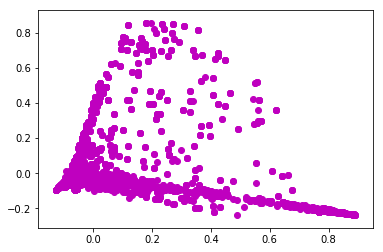

In [48]:
X_dense = X.todense()
coords = PCA(n_components=2).fit_transform(X_dense)
plt.scatter(coords[:, 0], coords[:, 1], c='m')
plt.show()

In [49]:
def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df
def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [54]:
features = vect.get_feature_names()
print(top_feats_in_doc(X, features, 1, 50))

         features     score
0        meetings  0.383128
1            trip  0.324351
2             ski  0.280451
3        business  0.276205
4           takes  0.204126
5             try  0.161225
6       presenter  0.158455
7       stimulate  0.155878
8           quiet  0.148051
9          speaks  0.148051
10     productive  0.145076
11         honest  0.140225
12         flying  0.139182
13        desired  0.133885
14           boat  0.130366
15           golf  0.126318
16      traveling  0.125302
17            jet  0.124813
18     suggestion  0.124336
19        holding  0.120896
20       opinions  0.116045
21        prepare  0.112680
22        suggest  0.111434
23          round  0.108736
24         formal  0.106745
25    discussions  0.104768
26         format  0.104097
27         austin  0.103770
28        waiting  0.102975
29           turn  0.102975
30     especially  0.102666
31   presentation  0.101478
32         groups  0.100771
33           rent  0.100359
34            fun  0

In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def parse_raw_message(raw_message):
    lines = raw_message.split('\n')
    email = {}
    message = ''
    keys_to_extract = ['from', 'to']
    for line in lines:
        if ':' not in line:
            message += line.strip()
            email['body'] = message
        else:
            pairs = line.split(':')
            key = pairs[0].lower()
            val = pairs[1].strip()
            if key in keys_to_extract:
                email[key] = val
    return email

def parse_into_emails(messages):
    emails = [parse_raw_message(message) for message in messages]
    return {
        'body': map_to_list(emails, 'body'), 
        'to': map_to_list(emails, 'to'), 
        'from_': map_to_list(emails, 'from')
    }

def map_to_list(emails, key):
    results = []
    for email in emails:
        if key not in email:
            results.append('')
        else:
            results.append(email[key])
    return results

def top_tfidf_feats(row, features, top_n=20):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats, columns=['features', 'score'])
    return df

def top_feats_in_doc(X, features, row_id, top_n=25):
    row = np.squeeze(X[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

def top_mean_feats(X, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []

    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(12, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Tf-Idf Score", labelpad=16, fontsize=14)
        ax.set_title("cluster = " + str(df.label), fontsize=16)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.score, align='center', color='#7530FF')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.features)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

In [58]:
def top_mean_feats(X, features,
 grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = X[grp_ids].toarray()
    else:
        D = X.toarray()
        D[D < min_tfidf] = 0
        tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [59]:
print(top_mean_feats(X, features, top_n=10))

   features     score
0     enron  0.044036
1       com  0.033229
2       ect  0.027058
3       hou  0.017350
4   message  0.016722
5  original  0.014824
6   phillip  0.012118
7     image  0.009894
8       gas  0.009022
9      john  0.008551


In [61]:
n_clusters = 3
clf = KMeans(n_clusters=n_clusters, max_iter=100, init='k-means++', n_init=1)
labels = clf.fit_predict(X)

In [67]:
X_dense = X.todense()
pca = PCA(n_components=2).fit(X_dense)
coords = pca.transform(X_dense)

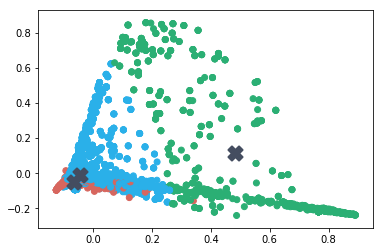

In [68]:
label_colors = ["#2AB0E9", "#2BAF74", "#D7665E", "#CCCCCC", 
                "#D2CA0D", "#522A64", "#A3DB05", "#FC6514"]
colors = [label_colors[i] for i in labels]

plt.scatter(coords[:, 0], coords[:, 1], c=colors)
#Plot the cluster centers
centroids = clf.cluster_centers_
centroid_coords = pca.transform(centroids)
plt.scatter(centroid_coords[:, 0], centroid_coords[:, 1], marker='X', s=200, linewidths=2, c='#444d60')
plt.show()

In [69]:
def top_feats_per_cluster(X, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label) 
        feats_df = top_mean_feats(X, features, ids,    min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs


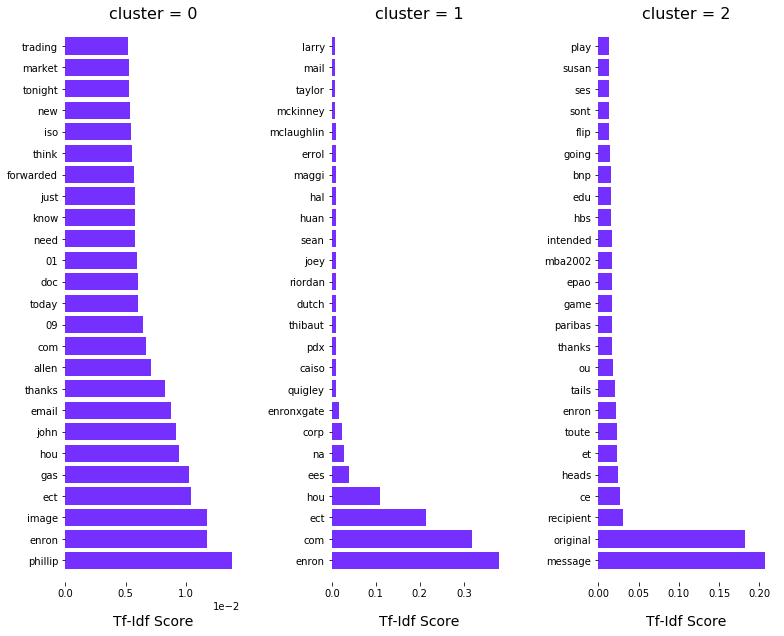

In [74]:
plot_tfidf_classfeats_h(top_feats_per_cluster(X, labels, features, 0.1, 25))